In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

In [2]:
df_train = pd.read_csv("BBC News Train.csv")
#print missing values
print("Nan in each columns:" , df_train.isna().sum(), sep='\n')

Nan in each columns:
ArticleId    0
Text         0
Category     0
dtype: int64


In [3]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df_train['category_id'] = df_train['Category'].factorize()[0]

In [5]:
df_train.groupby('Category').category_id.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

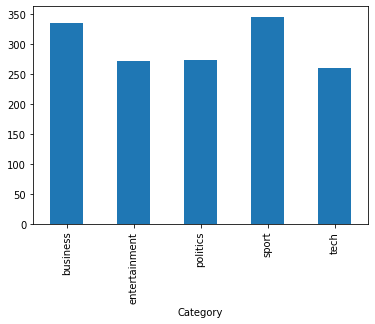

In [6]:
df_train.groupby('Category').category_id.count().plot.bar(ylim=0)

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_train.Text).toarray()
labels = df_train.category_id

In [8]:
category_to_id = {'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4}
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [9]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 


N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [10]:
##dimension reduction 


# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

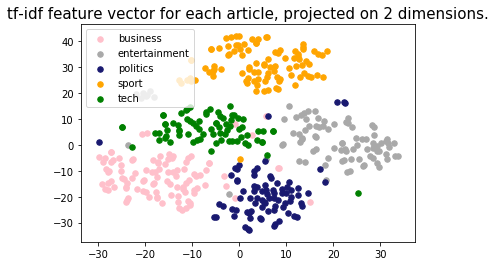

In [11]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [12]:
# define models to test:
base_models = [("Multinominal_Naivie_Bayes", MultinomialNB(),),
               ("LogisticRegression", LogisticRegression(random_state=0)),]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 10 # 10 = 90% train, 10% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    print(f"******** {name} ********")
    for score in ["accuracy", "precision_macro", "recall_macro", "f1_macro"]:
        print(f"{score}:", end=" ")  
        # get cross validation score for each model and each score metric:
        print(cross_val_score(model, features, labels, cv=split, scoring=score, n_jobs=-1).mean())

******** Multinominal_Naivie_Bayes ********
accuracy: 0.9711409395973154
precision_macro: 0.9702506738223977
recall_macro: 0.9710317689620347
f1_macro: 0.9700839120668807
******** LogisticRegression ********
accuracy: 0.974496644295302
precision_macro: 0.974997269435737
recall_macro: 0.9738762877490498
f1_macro: 0.9739067895258554


Accuracy of logistic regression: 0.99


Text(0.5, 15.0, 'Predicted')

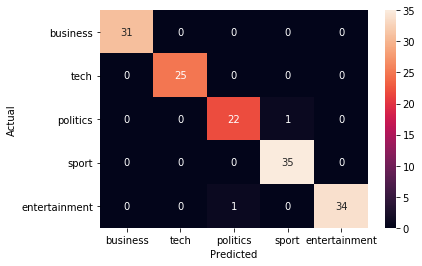

In [13]:
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_train.index, test_size=0.1, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


print('Accuracy of logistic regression: {:.2f}'.format(model.score(X_test, y_test)))


category_id_df = df_train[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Accuracy of multinomial naive bayes: 0.97


Text(0.5, 15.0, 'Predicted')

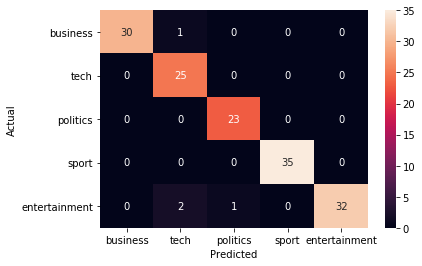

In [14]:
model = MultinomialNB()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_train.index, test_size=0.1, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


print('Accuracy of multinomial naive bayes: {:.2f}'.format(model.score(X_test, y_test)))


category_id_df = df_train[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')